In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
import sys

import pickle

import numpy as np
import pandas as pd

pd.options.display.float_format = "{:.5f}".format

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import PIL
from pillow_heif import register_heif_opener

register_heif_opener()

In [2]:
CWD = os.getcwd()
PY8TB_PATH = os.path.dirname(CWD)
SAVE_PATH = os.path.join(PY8TB_PATH, "data")
DF_PATH = os.path.join(SAVE_PATH, "df_2024_06_30_18_08_37.parquet.gzip")

In [3]:
sys.path.insert(0, PY8TB_PATH)

In [4]:
from py8tb import preprocessing_pipeline

# Análisis y preprocesamiento de df

In [5]:
df = preprocessing_pipeline(path=DF_PATH)

In [6]:
photos = df[df["FileType"] == "photo"]

In [7]:
with open(os.path.join(SAVE_PATH, "photos_sha256.pkl"), "rb") as f:
    photos_sha256 = pickle.load(f)
    photos_sha256 = pd.DataFrame(data=photos_sha256, columns=["FilePath", "Sha256"])

In [8]:
photos_sha256["Sha256"].apply(len).value_counts()

Sha256
64    114951
Name: count, dtype: int64

In [9]:
photos.head()

,FilePath,CreationDate,LastModificationDate,SizeMB,FileName,FileExtension,FileType
54,/Volumes/MUPU_4TB_1/code/kaggle_datasets/bobby...,2023-01-07 16:59:12,2020-07-20 11:58:42,0.29537,bobby.png,.png,photo
61,/Volumes/MUPU_4TB_1/code/kaggle_datasets/Denal...,2023-01-07 16:59:12,2020-01-25 15:33:18,0.02980,Denali Mt McKinley.jpg,.jpg,photo
67,/Volumes/MUPU_4TB_1/code/kaggle_datasets/Figur...,2023-01-07 16:59:11,2020-04-18 20:21:12,0.02575,FigureAxesMPL.png,.png,photo
81,/Volumes/MUPU_4TB_1/code/kaggle_datasets/Logis...,2023-01-07 16:59:09,2020-04-10 08:10:50,0.10171,LogisticRegression.jpg,.jpg,photo
86,/Volumes/MUPU_4TB_1/code/kaggle_datasets/MPLAr...,2023-01-07 17:00:12,2020-04-18 21:22:12,0.02580,MPLArchitecture.png,.png,photo


In [10]:
photos_sha256.head()

,FilePath,Sha256
0,/Volumes/MUPU_4TB_1/code/kaggle_datasets/bobby...,c299e1e38511f982498f8e181ca300fe3eddad8b241159...
1,/Volumes/MUPU_4TB_1/code/kaggle_datasets/Denal...,d9cd8cba8cc65cd24e7eb9b6537462488a47e286d7d719...
2,/Volumes/MUPU_4TB_1/code/kaggle_datasets/Figur...,7c3eff6b4237af20a75631867b93e91b13958e717637a6...
3,/Volumes/MUPU_4TB_1/code/kaggle_datasets/Logis...,26048ccd2858c3e090fec613141fbf9cbcad7b5a87923f...
4,/Volumes/MUPU_4TB_1/code/kaggle_datasets/MPLAr...,290ebbce76730269474a23a2f588860862868c2d939534...


In [11]:
photos = pd.merge(
    left=photos,
    right=photos_sha256,
    how="left",
    right_on="FilePath",
    left_on="FilePath",
)

In [12]:
photos.head()

,FilePath,CreationDate,LastModificationDate,SizeMB,FileName,FileExtension,FileType,Sha256
0,/Volumes/MUPU_4TB_1/code/kaggle_datasets/bobby...,2023-01-07 16:59:12,2020-07-20 11:58:42,0.29537,bobby.png,.png,photo,c299e1e38511f982498f8e181ca300fe3eddad8b241159...
1,/Volumes/MUPU_4TB_1/code/kaggle_datasets/Denal...,2023-01-07 16:59:12,2020-01-25 15:33:18,0.02980,Denali Mt McKinley.jpg,.jpg,photo,d9cd8cba8cc65cd24e7eb9b6537462488a47e286d7d719...
2,/Volumes/MUPU_4TB_1/code/kaggle_datasets/Figur...,2023-01-07 16:59:11,2020-04-18 20:21:12,0.02575,FigureAxesMPL.png,.png,photo,7c3eff6b4237af20a75631867b93e91b13958e717637a6...
3,/Volumes/MUPU_4TB_1/code/kaggle_datasets/Logis...,2023-01-07 16:59:09,2020-04-10 08:10:50,0.10171,LogisticRegression.jpg,.jpg,photo,26048ccd2858c3e090fec613141fbf9cbcad7b5a87923f...
4,/Volumes/MUPU_4TB_1/code/kaggle_datasets/MPLAr...,2023-01-07 17:00:12,2020-04-18 21:22:12,0.02580,MPLArchitecture.png,.png,photo,290ebbce76730269474a23a2f588860862868c2d939534...


In [26]:
SHA = (
    photos
    # .pipe(lambda df: df[df["FileExtension"] == ".heic"])
    ["Sha256"]
    .value_counts()
    .reset_index()
    .rename(columns={"count": "Count"})
    .pipe(lambda df: df[df["Count"] > 4])
    .sample(1)["Sha256"]
    .iloc[0]
)

In [27]:
def get_matplotlib_figure_params(paths: list[str]) -> tuple[int, int]:
    if (len(paths) % 3) == 0:
        return (int(len(paths) / 3), 3)
    elif (len(paths) % 2) == 0:
        return (int(len(paths) / 2), 2)
    else:
        return (int(len(paths) / 2) + 1, 2)

In [28]:
def plot_duplicated_photos(sha: str, photos: pd.DataFrame) -> None:

    # get the path to plot/show images
    paths = photos[photos["Sha256"].str.contains(sha)]["FilePath"].tolist()
    nr_rows, nr_columns = get_matplotlib_figure_params(paths=paths)

    # plotting with matplotlib
    fig = plt.figure(figsize=(15, 5))
    axes = fig.subplots(nr_rows, nr_columns).flatten()

    for path, ax in zip(paths, axes):
        ax.imshow(PIL.Image.open(path))

In [29]:
photos[photos["Sha256"].str.contains(SHA)]

,FilePath,CreationDate,LastModificationDate,SizeMB,FileName,FileExtension,FileType,Sha256
10951,/Volumes/MUPU_4TB_1/MUPU 500GB/Fotos/(2016-08-...,2021-08-07 20:04:23,2019-08-28 04:10:56,4.46151,(2016-08-11 21-48-56)-5312x2988-116016960.JPEG,.jpeg,photo,eca6ce51885fe80a8068e6a87abae248f4d90a5c2cb6cb...
10952,/Volumes/MUPU_4TB_1/MUPU 500GB/Fotos/(2016-08-...,2021-08-07 20:04:23,2019-08-28 03:56:25,4.46151,(2016-08-11 21-48-56)-5312x2988-229237888.JPEG,.jpeg,photo,eca6ce51885fe80a8068e6a87abae248f4d90a5c2cb6cb...
10953,/Volumes/MUPU_4TB_1/MUPU 500GB/Fotos/(2016-08-...,2021-08-07 20:04:23,2019-08-28 03:42:40,4.46151,(2016-08-11 21-48-56)-5312x2988-359282992.JPEG,.jpeg,photo,eca6ce51885fe80a8068e6a87abae248f4d90a5c2cb6cb...
10954,/Volumes/MUPU_4TB_1/MUPU 500GB/Fotos/(2016-08-...,2021-08-07 20:04:23,2019-08-28 03:31:08,4.46151,(2016-08-11 21-48-56)-5312x2988-489790392.JPEG,.jpeg,photo,eca6ce51885fe80a8068e6a87abae248f4d90a5c2cb6cb...
10955,/Volumes/MUPU_4TB_1/MUPU 500GB/Fotos/(2016-08-...,2021-08-07 20:04:23,2019-08-28 04:18:52,4.46151,(2016-08-11 21-48-56)-5312x2988-62572936.JPEG,.jpeg,photo,eca6ce51885fe80a8068e6a87abae248f4d90a5c2cb6cb...
10956,/Volumes/MUPU_4TB_1/MUPU 500GB/Fotos/(2016-08-...,2021-08-07 20:04:24,2019-08-28 04:17:42,4.46151,(2016-08-11 21-48-56)-5312x2988-67798352.JPEG,.jpeg,photo,eca6ce51885fe80a8068e6a87abae248f4d90a5c2cb6cb...


In [50]:
SHA

'eca6ce51885fe80a8068e6a87abae248f4d90a5c2cb6cbe742b7703173d2cb01'

In [34]:
total_photos = photos["FileType"].value_counts().iloc[0]

In [38]:
unique_photos = photos.groupby(["Sha256"]).size().size

In [39]:
duplicates_photos = total_photos - unique_photos

In [43]:
photos["DummyValue"] = 1

In [53]:
photos.groupby(["Sha256"]).get_group((SHA))["DummyValue"].cumsum()

10951    1
10952    2
10953    3
10954    4
10955    5
10956    6
Name: DummyValue, dtype: int64

In [71]:
%%timeit
photos["CumSum"] = photos.groupby(["Sha256"])["DummyValue"].transform(
    lambda series: series.cumsum()
)

2.73 s ± 9.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [72]:
sha256_list = photos["Sha256"].values.tolist()
path_list = photos["FilePath"].values.tolist()

In [73]:
assert len(sha256_list) == len(path_list)

In [77]:
%%timeit

dict_sha256_to_save = {}
dict_sha256_to_delete = {}

for sha256_, path_ in zip(sha256_list, path_list):
    if sha256_ not in dict_sha256_to_save.keys():
        dict_sha256_to_save[sha256_] = path_
    else:
        dict_sha256_to_delete[path_] = sha256_

13.8 ms ± 34.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [75]:
len(dict_sha256_to_save)

79343

In [76]:
len(dict_sha256_to_delete)

35608

In [56]:
unique_photos_df = photos[photos["CumSum"] == 1]

In [58]:
unique_photos_df.shape

(79343, 10)

In [61]:
unique_photos_df

,FilePath,CreationDate,LastModificationDate,SizeMB,FileName,FileExtension,FileType,Sha256,DummyValue,CumSum
0,/Volumes/MUPU_4TB_1/code/kaggle_datasets/bobby...,2023-01-07 16:59:12,2020-07-20 11:58:42,0.29537,bobby.png,.png,photo,c299e1e38511f982498f8e181ca300fe3eddad8b241159...,1,1
1,/Volumes/MUPU_4TB_1/code/kaggle_datasets/Denal...,2023-01-07 16:59:12,2020-01-25 15:33:18,0.02980,Denali Mt McKinley.jpg,.jpg,photo,d9cd8cba8cc65cd24e7eb9b6537462488a47e286d7d719...,1,1
2,/Volumes/MUPU_4TB_1/code/kaggle_datasets/Figur...,2023-01-07 16:59:11,2020-04-18 20:21:12,0.02575,FigureAxesMPL.png,.png,photo,7c3eff6b4237af20a75631867b93e91b13958e717637a6...,1,1
3,/Volumes/MUPU_4TB_1/code/kaggle_datasets/Logis...,2023-01-07 16:59:09,2020-04-10 08:10:50,0.10171,LogisticRegression.jpg,.jpg,photo,26048ccd2858c3e090fec613141fbf9cbcad7b5a87923f...,1,1
4,/Volumes/MUPU_4TB_1/code/kaggle_datasets/MPLAr...,2023-01-07 17:00:12,2020-04-18 21:22:12,0.02580,MPLArchitecture.png,.png,photo,290ebbce76730269474a23a2f588860862868c2d939534...,1,1
...,...,...,...,...,...,...,...,...,...,...
114946,/Volumes/MUPU_4TB_2/BACKUPS/OnePlus8Pro_241220...,2023-12-24 17:35:23,2023-12-15 08:58:59,0.78631,Screenshot_2023-12-15-08-58-59-57_0438eb925998...,.jpg,photo,9cc7c4ee5ca8ef6fb29157c59c2b679f095b33958a8fc2...,1,1
114947,/Volumes/MUPU_4TB_2/BACKUPS/OnePlus8Pro_241220...,2023-12-24 17:35:23,2023-12-15 08:59:36,0.60291,Screenshot_2023-12-15-08-59-36-23_0438eb925998...,.jpg,photo,de533ef2d74d392fbe299b5f660085c68d80f7bd2f4ed3...,1,1
114948,/Volumes/MUPU_4TB_2/BACKUPS/OnePlus8Pro_241220...,2023-12-24 17:35:23,2023-12-15 08:59:43,0.74182,Screenshot_2023-12-15-08-59-43-02_0438eb925998...,.jpg,photo,aecf2a050268d450ae58d1862d97033e17def804db7a49...,1,1
114949,/Volumes/MUPU_4TB_2/BACKUPS/OnePlus8Pro_241220...,2023-12-24 17:35:23,2023-12-15 09:00:28,0.56253,Screenshot_2023-12-15-09-00-28-02_0438eb925998...,.jpg,photo,5897ccba227f7ef3bfd65fd5eff81d3318ff3a82cc6587...,1,1


In [59]:
unique_photos

79343

In [62]:
duplicates_photos_df = photos[photos["CumSum"] != 1]

In [64]:
duplicates_photos_df.shape

(35608, 10)

In [65]:
duplicates_photos

35608

In [66]:
duplicates_photos

35608

In [69]:
duplicates_photos_df["FilePath"].iloc[0]

'/Volumes/MUPU_4TB_1/code/kaggle_datasets/FUTURES SALES/XGBRegressor_2020_06_04_20_32_12_plot_importance.png'

In [70]:
# os.remove(duplicates_photos_df["FilePath"].iloc[0])

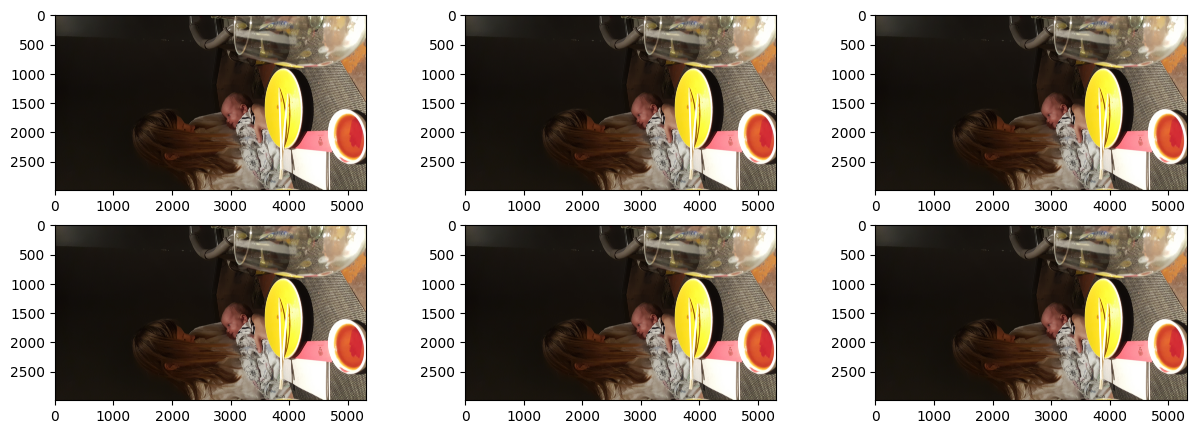

In [32]:
paths = plot_duplicated_photos(sha=SHA, photos=photos)

In [ ]:
def parse_date(filename, split_by_text):

    splitted_filename = filename.split(split_by_text)[1].split(".")[0]

    if (len(splitted_filename) >= 8) and (split_by_text in ["IMG_", "IMG-"]):
        return splitted_filename[:8]

    elif "Screenshot_" in filename:
        return splitted_filename[:10].replace("-", "")

    else:
        return filename

In [ ]:
def extract_creation_date_from_photo_name(row):

    creation_date = row["CreationDate"]
    last_modification_date = row["LastModificationDate"]
    filename = row["FileName"]

    if "IMG_" in filename:
        return parse_date(filename=filename, split_by_text="IMG_")

    elif "IMG-" in filename:
        return parse_date(filename=filename, split_by_text="IMG-")

    elif "Screenshot_" in filename:
        return parse_date(filename=filename, split_by_text="Screenshot_")

    else:
        return filename

In [ ]:
def parse_date_with_regex(filename):

    import re

    regex_rule = re.compile(pattern="\d{8}|\d{4}-\d{2}-\d{2}")
    results = regex_rule.findall(filename)

    if len(results) > 0:

        if "-" in results[0]:
            return results[0].replace("-", "")

        else:
            return results[0]

    else:
        return filename

In [ ]:
sdf = df[(df["FileType"] == "photo")].sample(50)

In [ ]:
sdf["ParseCreationDate"] = sdf.apply(extract_creation_date_from_photo_name, axis=1)

In [ ]:
sdf["ParseCreationDateWithRegex"] = sdf["FileName"].apply(parse_date_with_regex)

In [ ]:
sdf

In [ ]:
top_file_extesions = pd.concat(
    [
        df["FileExtension"].value_counts(),
        df["FileExtension"].value_counts(normalize=True),
    ],
    axis=1,
).assign(CumSum=lambda df: df["proportion"].cumsum())

In [ ]:
# Using top 20 file extesions we created the TOP_FILE_EXTENSIONS
# and mapped it to the file type (audio, video, photo etc)
top_file_extesions.head(20)

In [ ]:
file_size_and_counter_by_type = (
    df.groupby(["FileExtension", "FileType"])
    .agg(
        NrFiles=("FilePath", len),
        TotalSizeMB=("SizeMB", np.sum),
        TotalSizeGB=("SizeMB", lambda series: np.sum(series) / (1024)),  # GB
    )
    .reset_index()
    .assign(
        NrFilesByType=lambda df: df.groupby("FileType")["NrFiles"].transform(np.sum),
        TotalSizeMBByType=lambda df: df.groupby("FileType")["TotalSizeMB"].transform(
            np.sum
        ),
        PctNrFilesByType=lambda df: df["NrFiles"] / df["NrFilesByType"],
        PctSizeMBByType=lambda df: df["TotalSizeMB"] / df["TotalSizeMBByType"],
    )
    .query("FileType == 'video' or FileType == 'photo'")
    .sort_values("FileType", ascending=False)
)

In [ ]:
file_size_and_counter_by_type